### EMA(지수이동 평균)
- 최근 데이터에 더 큰 가중치를 부여하여 계산
- sma에 비해 최근 변화에 더 민감하게 반응
- 지수 가중치를 사용하여 과거 데이터의 영향력을 점진적으로 줄여가며 계산

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install CatBoost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 18.4 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, auc, precision_recall_curve, confusion_matrix,
                           classification_report, average_precision_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve
from itertools import cycle

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/merged_V2.csv')
df = data

In [ ]:
# EMA를 적용할 좌표 열 리스트
coordinate_columns = [col for col in df.columns if '_x' in col or '_y' in col]

# EMA 계산 함수
def apply_ema(df, window_size):
    return df.ewm(span=window_size, adjust=False).mean()

# window size 설정 (예: 10 프레임)
window_size = 10

# 각 좌표 열에 대해 EMA 적용
for col in coordinate_columns:
    df[f"{col}_EMA"] = apply_ema(df[col], window_size)

df.head()

,image_filename,Nose_x,Nose_y,LEye_x,LEye_y,REye_x,REye_y,LEar_x,LEar_y,REar_x,...,RBigToe_x_EMA,RBigToe_y_EMA,LSmallToe_x_EMA,LSmallToe_y_EMA,RSmallToe_x_EMA,RSmallToe_y_EMA,LHeel_x_EMA,LHeel_y_EMA,RHeel_x_EMA,RHeel_y_EMA
0,0.jpg,1368.317139,245.318161,1375.947510,242.774719,1368.317139,240.231262,1388.664673,245.318161,1386.121338,...,1355.599976,466.598053,1360.686768,466.598053,1355.599976,464.054596,1383.577881,456.424255,1386.121338,456.424255
1,1.jpg,1367.379517,245.956863,1375.112671,240.801453,1367.379517,240.801453,1388.001221,245.956863,1385.423462,...,1355.398338,466.318701,1360.497625,466.787373,1355.398338,463.769012,1383.913441,456.588662,1385.994451,456.588662
2,2.jpg,1365.833862,248.601212,1373.505005,243.487152,1365.833862,243.487152,1386.290161,246.044174,1383.733032,...,1355.436064,466.251394,1360.073119,466.634854,1355.436064,463.700370,1383.415729,456.895712,1386.513127,456.430796
3,3.jpg,1365.026855,247.695007,1372.763184,242.537491,1365.026855,242.537491,1385.656982,247.695007,1380.499390,...,1355.304401,466.367369,1360.036077,466.681108,1355.304401,463.811306,1382.885486,457.306125,1386.826325,456.456878
4,4.jpg,1362.091553,247.426620,1369.815674,242.277222,1364.666260,239.702530,1382.689209,247.426620,1380.114502,...,1355.134043,466.350767,1359.941671,466.607463,1355.134043,463.791320,1383.786056,457.532642,1387.010380,456.369676


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


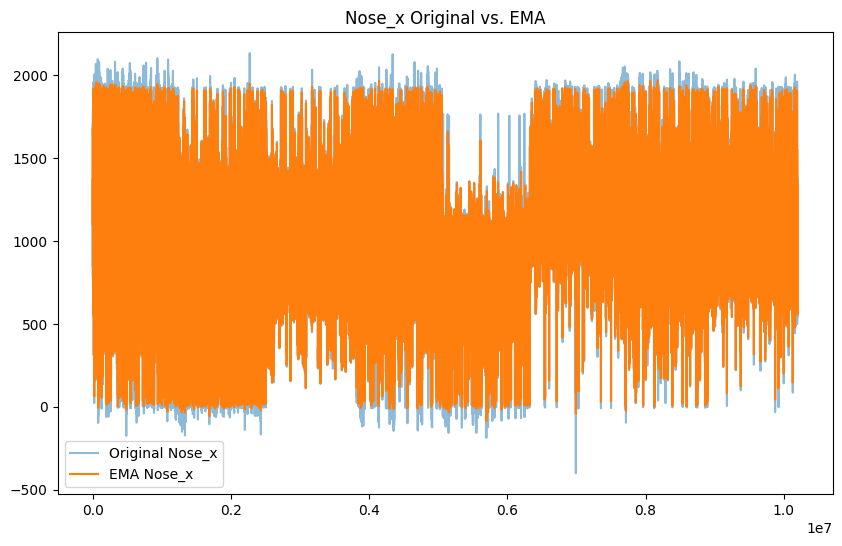

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['Nose_x'], label='Original Nose_x', alpha=0.5)
plt.plot(data['Nose_x_EMA'], label='EMA Nose_x')
plt.legend()
plt.title("Nose_x Original vs. EMA")
plt.show()

In [ ]:
import numpy as np

def add_adversarial_noise_optimized(df, epsilon=2.0):
    # 필요한 컬럼 리스트
    sma_columns = [col for col in df.columns if col.endswith("_EMA") and ('_x' in col or '_y' in col)]
    # 원본 복사는 최소한으로 (필요한 부분만 복사)
    df_adv = df.copy(deep=False)  # 얕은 복사: 메모리 사용량이 줄어듦 (단, 내부 데이터가 수정되면 원본에도 영향이 있을 수 있음)

    # 모든 SMA 컬럼에 대해 한 번에 noise 행렬 생성 후 적용
    noise = np.random.uniform(-epsilon, epsilon, size=(df_adv.shape[0], len(sma_columns)))
    df_adv.loc[:, sma_columns] = df_adv.loc[:, sma_columns] + noise
    return df_adv

# 최적화된 함수 사용
df_adv = add_adversarial_noise_optimized(df, epsilon=2.0)

In [ ]:
df = df.drop(['image_filename', 'Nose_x', 'Nose_y', 'LEye_x', 'LEye_y', 'REye_x', 'REye_y', 'LEar_x', 'LEar_y', 'REar_x', 'REar_y', 'LShoulder_x', 'LShoulder_y', 'RShoulder_x', 'RShoulder_y', 'LElbow_x', 'LElbow_y', 'RElbow_x', 'RElbow_y', 'LWrist_x', 'LWrist_y', 'RWrist_x', 'RWrist_y', 'LHip_x', 'LHip_y', 'RHip_x', 'RHip_y', 'LKnee_x', 'LKnee_y', 'RKnee_x', 'RKnee_y', 'LAnkle_x', 'LAnkle_y', 'RAnkle_x', 'RAnkle_y', 'Head_x', 'Head_y', 'Neck_x', 'Neck_y', 'Hip_x', 'Hip_y', 'LBigToe_x', 'LBigToe_y', 'RBigToe_x', 'RBigToe_y', 'LSmallToe_x', 'LSmallToe_y', 'RSmallToe_x', 'RSmallToe_y', 'LHeel_x', 'LHeel_y', 'RHeel_x', 'RHeel_y', 'gender', 'level','path'], axis=1)

In [ ]:
encoder = LabelEncoder()
encoder.fit(data['label'])

df["label"] = encoder.transform(data['label'])
# 0 = jump, 1 = spin, 2 = step

In [ ]:
X = df.drop(['label'] , axis=1)
Y = df['label']

print(X.shape)
print(Y.shape)

(10196123, 52)
(10196123,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(6525518, 52)
(2039225, 52)
(6525518,)
(2039225,)
(1631380, 52)
(1631380,)


In [ ]:
!sudo fallocate -l 16G /swapfile
!sudo chmod 600 /swapfile
!sudo mkswap /swapfile
!sudo swapon /swapfile
!free -h  # RAM & Swap 확인

Setting up swapspace version 1, size = 16 GiB (17179865088 bytes)
no label, UUID=d7e0035e-937b-4495-b55a-d0ce9b7aa621
swapon: /swapfile: swapon failed: Invalid argument
               total        used        free      shared  buff/cache   available
Mem:            50Gi        22Gi       4.6Gi       1.0Mi        23Gi        27Gi
Swap:             0B          0B          0B


In [ ]:
# 모델 정의
models = {
    'Extra Trees': ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(iterations=50, random_state=42, verbose=0),
    'LightGBM': LGBMClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    #'XGBoost': XGBClassifier(n_estimators=50, random_state=42, n_jobs=-1),
    #'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
}

In [ ]:
kf = KFold(n_splits=5, shuffle=False)
cv_scores = []

In [ ]:
test_predictions = {name: np.zeros((X_test.shape[0], len(np.unique(Y_test)))) for name in models.keys()}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\n=== Fold {fold+1} ===")

    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

    for name, model in models.items():
        print(f"Training {name}...")

        model.fit(X_train_fold, Y_train_fold)

         # 훈련 세트 성능 평가
        Y_train_pred = model.predict(X_train_fold)
        print("\n--- Training Set Performance ---")
        print(classification_report(Y_train_fold, Y_train_pred))

        # 검증 세트 성능 평가
        Y_val_pred = model.predict(X_val_fold)
        print("\n--- Validation Set Performance ---")
        print(classification_report(Y_val_fold, Y_val_pred))

        # Test Set 예측값 저장 (Soft Voting을 위해 확률 예측값 사용)
        test_predictions[name] += model.predict_proba(X_test) / kf.n_splits  # 평균 계산

# 최종 테스트 세트 평가 (앙상블 방식)
for name, pred_proba in test_predictions.items():
    print(f"\n=== Final Test Evaluation ({name}) - Averaged Over Folds ===")

    # 확률 예측값을 가장 높은 클래스 선택으로 변환
    Y_test_pred = np.argmax(pred_proba, axis=1)

    print("\n--- Test Set Performance ---")
    print(classification_report(Y_test, Y_test_pred))


=== Fold 1 ===
Training Extra Trees...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2357516
           1       1.00      1.00      1.00   1681554
           2       1.00      1.00      1.00   1181344

    accuracy                           1.00   5220414
   macro avg       1.00      1.00      1.00   5220414
weighted avg       1.00      1.00      1.00   5220414


--- Validation Set Performance ---
              precision    recall  f1-score   support

           0       0.90      0.93      0.92    590021
           1       0.91      0.90      0.90    420720
           2       0.92      0.86      0.89    294363

    accuracy                           0.91   1305104
   macro avg       0.91      0.90      0.90   1305104
weighted avg       0.91      0.91      0.91   1305104

Training CatBoost...

--- Training Set Performance ---
              precision    recall  f1-score   support

           0      


=== Confusion Matrix (Extra Trees) ===


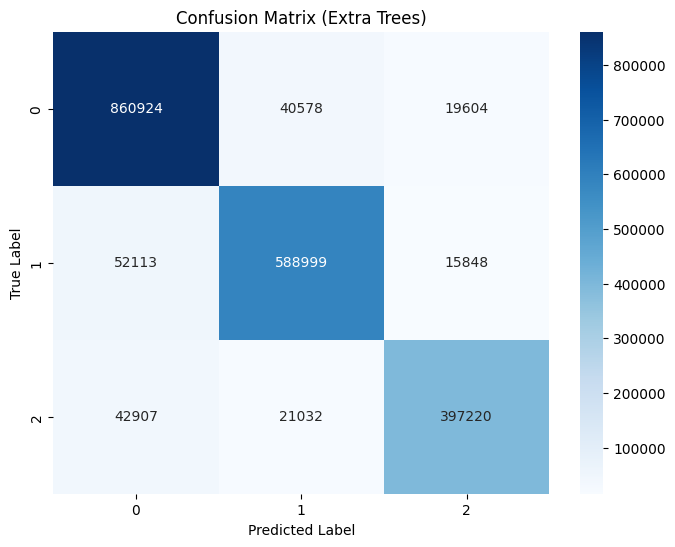


=== Confusion Matrix (CatBoost) ===


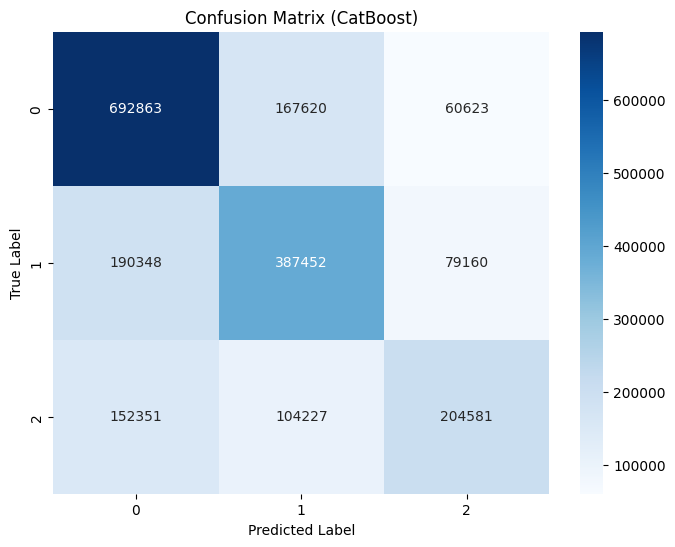


=== Confusion Matrix (LightGBM) ===


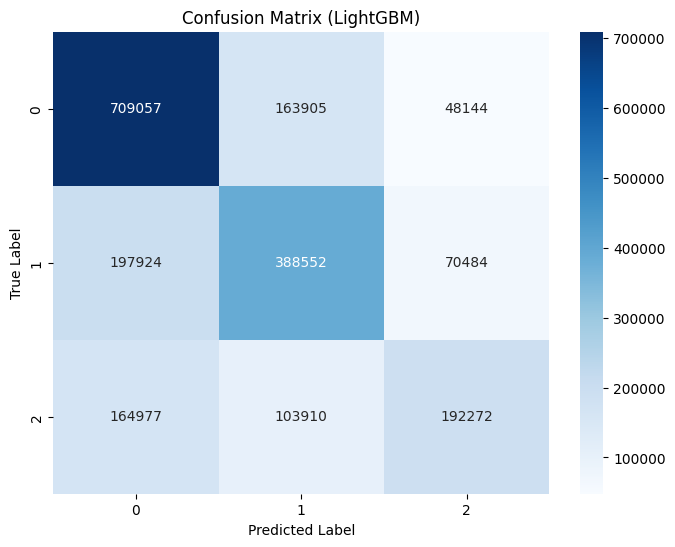

In [ ]:
class_names = np.unique(Y_test)

for name, model in models.items():
    print(f"\n=== Confusion Matrix ({name}) ===")

    Y_test_pred = model.predict(X_test)

    cm = confusion_matrix(Y_test, Y_test_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f'Confusion Matrix ({name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


=== Evaluating Extra Trees ===
Extra Trees Y_test_pred shape: (2039225,)
Extra Trees Y_test_pred (first 5): [0 1 1 1 0]


<ipython-input-18-07e9d1d5386d>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


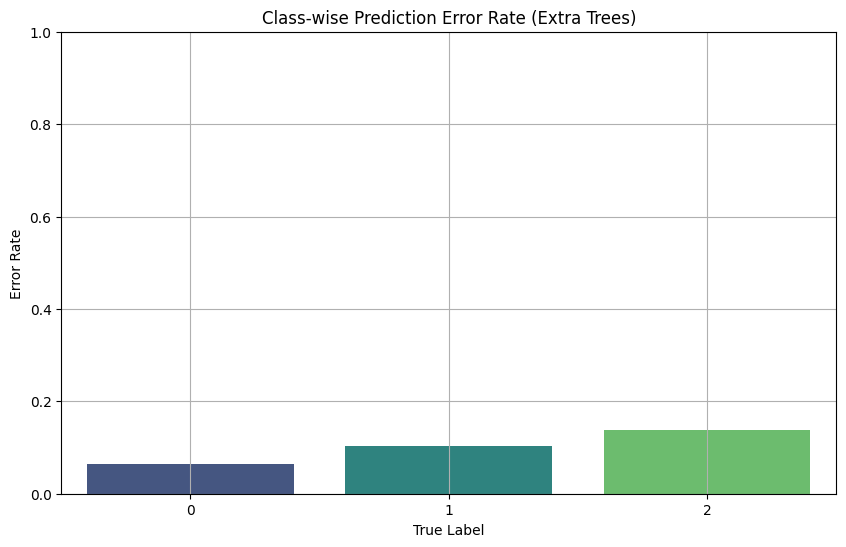

True Label
0    0.065337
1    0.103448
2    0.138648
Name: Error, dtype: float64

=== Evaluating CatBoost ===
CatBoost Y_test_pred shape: (2039225, 1)
CatBoost Y_test_pred (first 5): [0 0 1 1 0]


<ipython-input-18-07e9d1d5386d>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


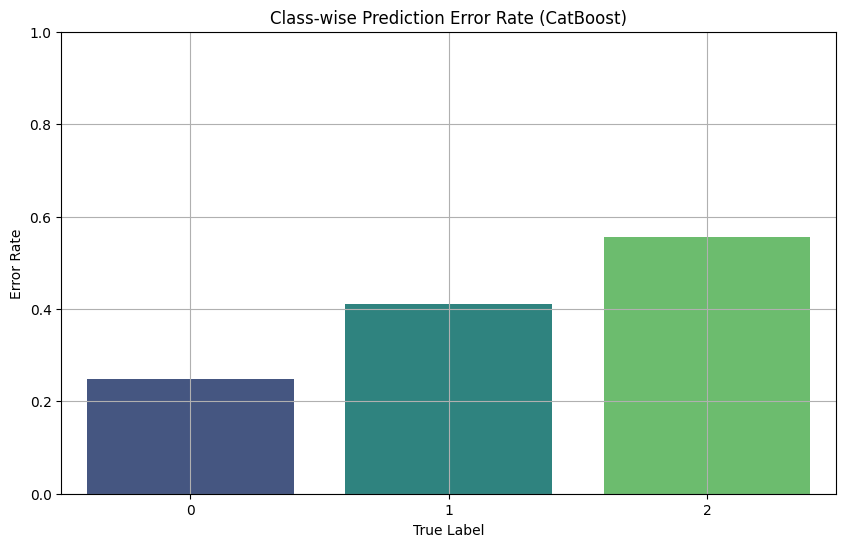

True Label
0    0.247792
1    0.410235
2    0.556376
Name: Error, dtype: float64

=== Evaluating LightGBM ===
LightGBM Y_test_pred shape: (2039225,)
LightGBM Y_test_pred (first 5): [0 1 1 1 0]


<ipython-input-18-07e9d1d5386d>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")


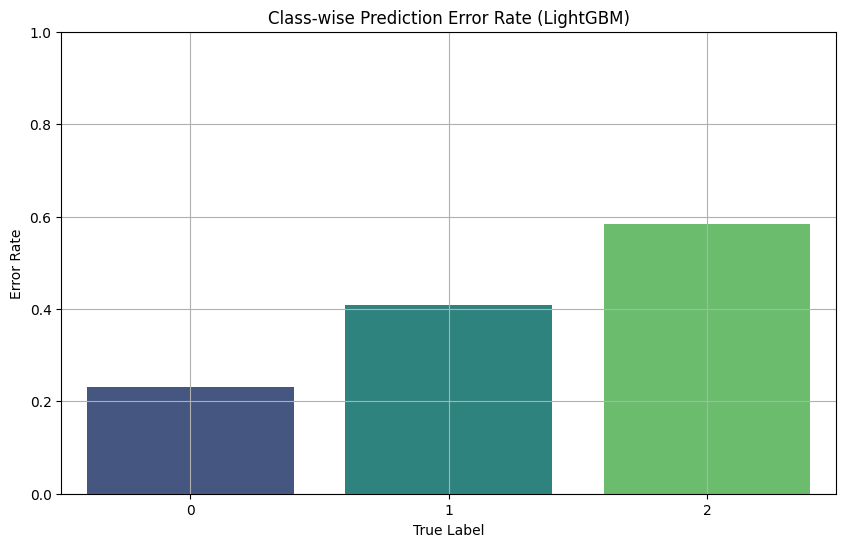

True Label
0    0.230211
1    0.408561
2    0.583068
Name: Error, dtype: float64


In [ ]:
for name, model in models.items():
    print(f"\n=== Evaluating {name} ===")

    # 예측값 생성
    Y_test_pred = model.predict(X_test)

    # 예측값 차원 확인
    print(f"{name} Y_test_pred shape: {Y_test_pred.shape}")

    # 1차원 변환 (필요할 경우)
    if Y_test_pred.ndim > 1:
        if Y_test_pred.shape[1] > 1:
            print(f"Warning: {name} predict() returned probabilities! Using argmax().")
            Y_test_pred = Y_test_pred.argmax(axis=1)
        else:
            Y_test_pred = Y_test_pred.ravel()

    print(f"{name} Y_test_pred (first 5): {Y_test_pred[:5]}")

    # 예측 오류 분석
    error = pd.DataFrame({
        "True Label": Y_test,
        "Predicted Label": Y_test_pred
    })

    error["Error"] = (error["True Label"] != error["Predicted Label"]).astype(int)
    classwise_error = error.groupby("True Label")["Error"].mean()

    # 클래스별 오류 비율 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=classwise_error.index, y=classwise_error.values, palette="viridis")
    plt.title(f"Class-wise Prediction Error Rate ({name})")
    plt.xlabel("True Label")
    plt.ylabel("Error Rate")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    print(classwise_error)



=== ROC Curve Analysis (Extra Trees) ===


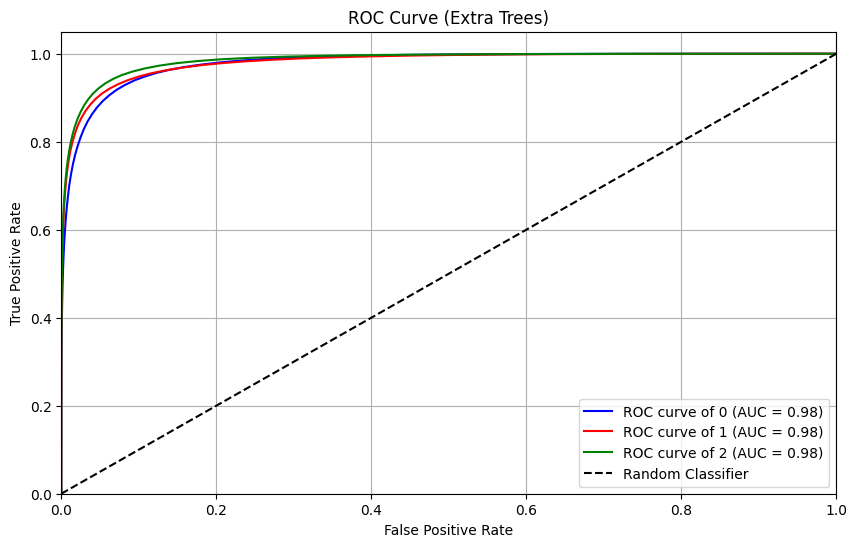


=== AUC Scores ===
0: 0.979
1: 0.981
2: 0.985

=== ROC Curve Analysis (CatBoost) ===


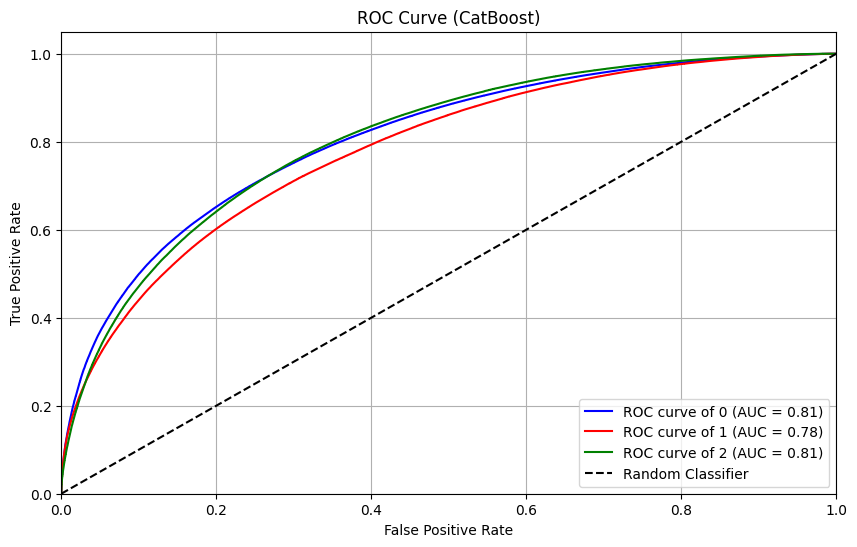


=== AUC Scores ===
0: 0.808
1: 0.783
2: 0.807

=== ROC Curve Analysis (LightGBM) ===


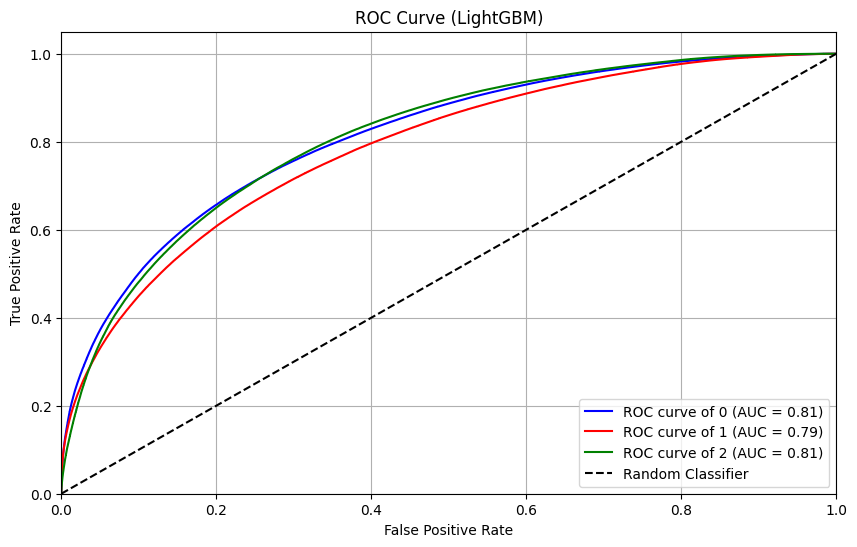


=== AUC Scores ===
0: 0.811
1: 0.786
2: 0.811


In [ ]:
for name, model in models.items():
    print(f"\n=== ROC Curve Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 FPR, TPR, AUC 저장
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    auc_scores = {}

    # 클래스별 ROC 곡선 계산
    for i, class_name in enumerate(np.unique(Y)):
        fpr[i], tpr[i], _ = roc_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 ROC 변환
            y_pred_proba[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])
        auc_scores[class_name] = roc_auc[i]

    # ROC 커브 그리기
    plt.figure(figsize=(10, 6))
    colors = cycle(['blue', 'red', 'green'])

    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            label=f'ROC curve of {class_name} (AUC = {roc_auc[i]:.2f})'
        )

    # 완벽한 예측선을 추가
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({name})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # AUC 점수 출력
    print("\n=== AUC Scores ===")
    for class_name, score in auc_scores.items():
        print(f"{class_name}: {score:.3f}")




=== Precision-Recall Curve Analysis (Extra Trees) ===


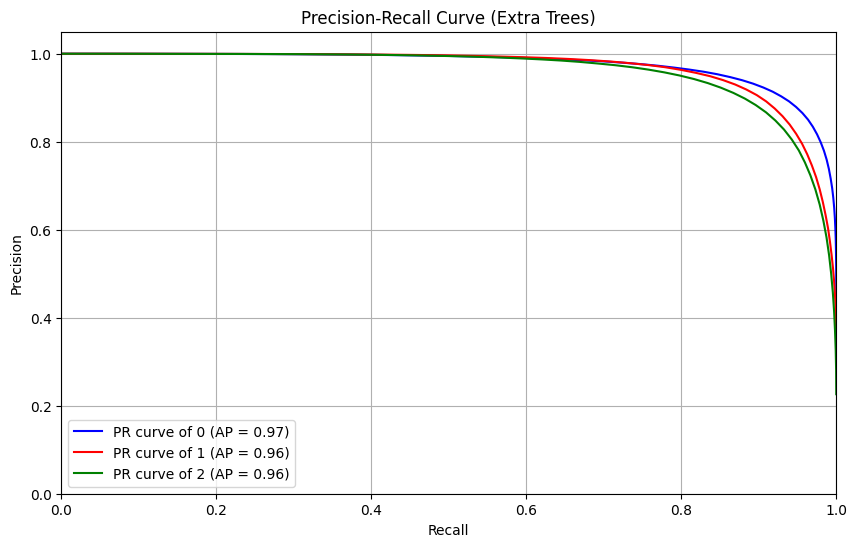


=== Average Precision Scores ===
0: 0.973
1: 0.965
2: 0.957

=== Precision-Recall Curve Analysis (CatBoost) ===


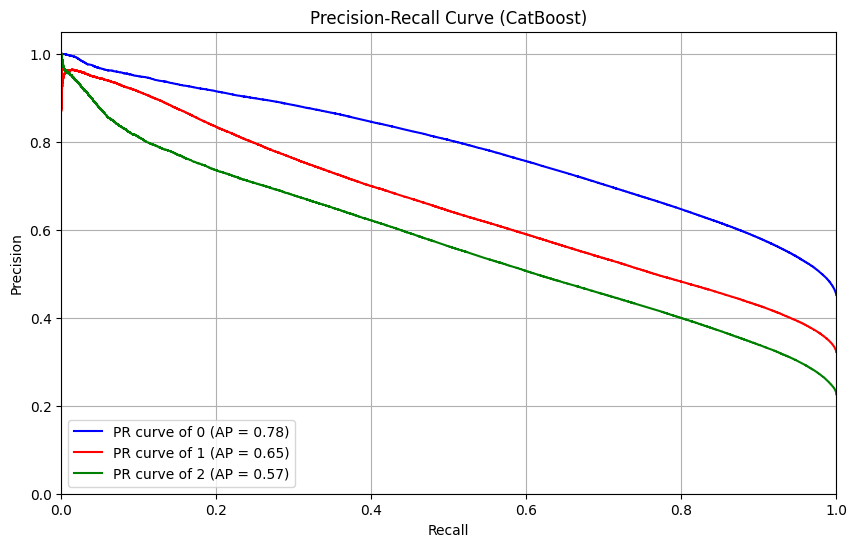


=== Average Precision Scores ===
0: 0.782
1: 0.655
2: 0.571

=== Precision-Recall Curve Analysis (LightGBM) ===


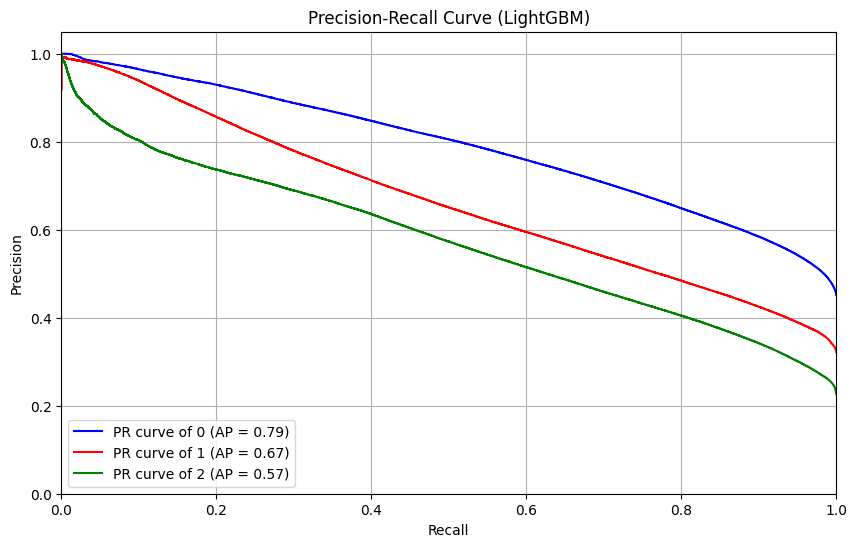


=== Average Precision Scores ===
0: 0.788
1: 0.665
2: 0.575


In [ ]:
for name, model in models.items():
    print(f"\n=== Precision-Recall Curve Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 Precision, Recall, AP 저장
    precision = dict()
    recall = dict()
    avg_precision = dict()
    ap_scores = {}

    # 클래스별 PR 곡선 계산
    for i, class_name in enumerate(np.unique(Y)):
        precision[i], recall[i], _ = precision_recall_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 PR 변환
            y_pred_proba[:, i]
        )
        avg_precision[i] = average_precision_score(
            (Y_test == class_name).astype(int),
            y_pred_proba[:, i]
        )
        ap_scores[class_name] = avg_precision[i]

    # PR 커브 그리기
    plt.figure(figsize=(10, 6))
    colors = cycle(['blue', 'red', 'green'])

    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        plt.plot(
            recall[i],
            precision[i],
            color=color,
            label=f'PR curve of {class_name} (AP = {avg_precision[i]:.2f})'
        )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({name})')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    # AP 점수 출력
    print("\n=== Average Precision Scores ===")
    for class_name, score in ap_scores.items():
        print(f"{class_name}: {score:.3f}")


=== Calibration Analysis (Extra Trees) ===


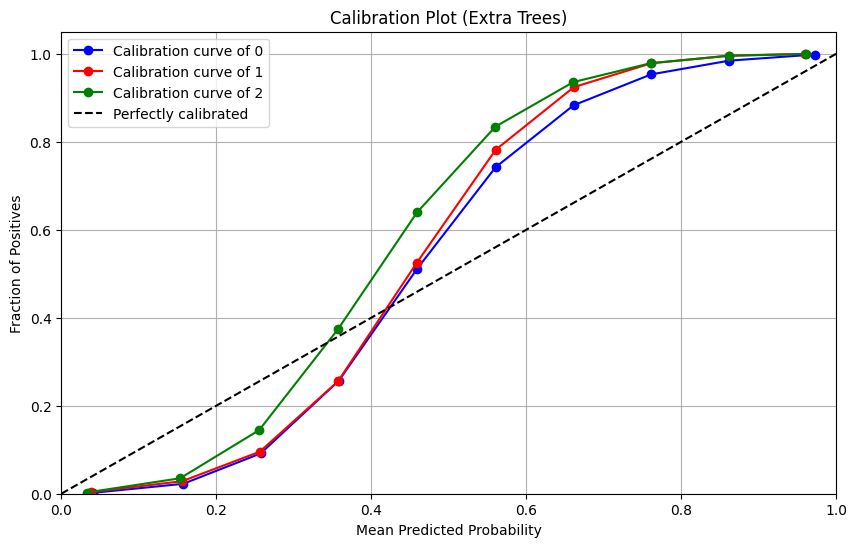


=== Calibration Scores ===
0: 0.124
1: 0.137
2: 0.139

=== Calibration Analysis (CatBoost) ===


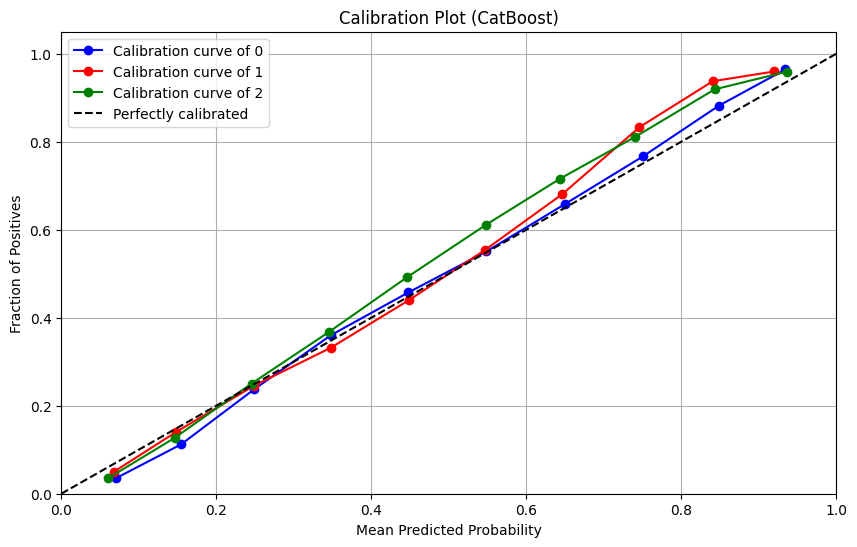


=== Calibration Scores ===
0: 0.020
1: 0.032
2: 0.042

=== Calibration Analysis (LightGBM) ===


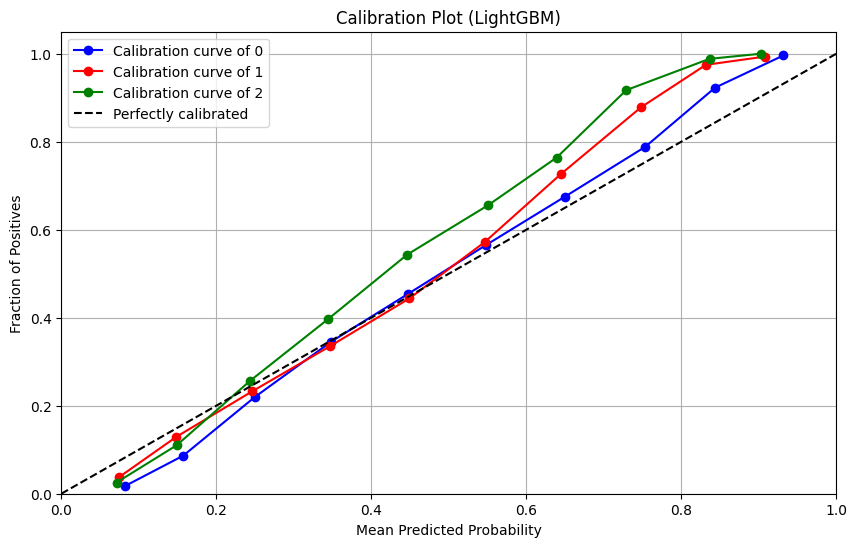


=== Calibration Scores ===
0: 0.040
1: 0.055
2: 0.091


In [ ]:
for name, model in models.items():
    print(f"\n=== Calibration Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 Calibration 정보 저장
    prob_true = dict()
    prob_pred = dict()
    calibration_scores = {}

    # 그래프 색상 설정
    colors = cycle(['blue', 'red', 'green'])

    # 캘리브레이션 곡선 계산
    plt.figure(figsize=(10, 6))
    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        prob_true[i], prob_pred[i] = calibration_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 변환
            y_pred_proba[:, i],
            n_bins=10
        )
        # 신뢰도 계산 (절대 오차의 평균)
        calibration_scores[class_name] = np.mean(np.abs(prob_true[i] - prob_pred[i]))

        # Calibration Curve 그리기
        plt.plot(
            prob_pred[i],
            prob_true[i],
            marker='o',
            color=color,
            label=f'Calibration curve of {class_name}'
        )

    # 완벽히 보정된 모델 기준선 추가
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Plot ({name})')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # Calibration Score 출력
    print("\n=== Calibration Scores ===")
    for class_name, score in calibration_scores.items():
        print(f"{class_name}: {score:.3f}")


=== Calibration Analysis (Extra Trees) ===


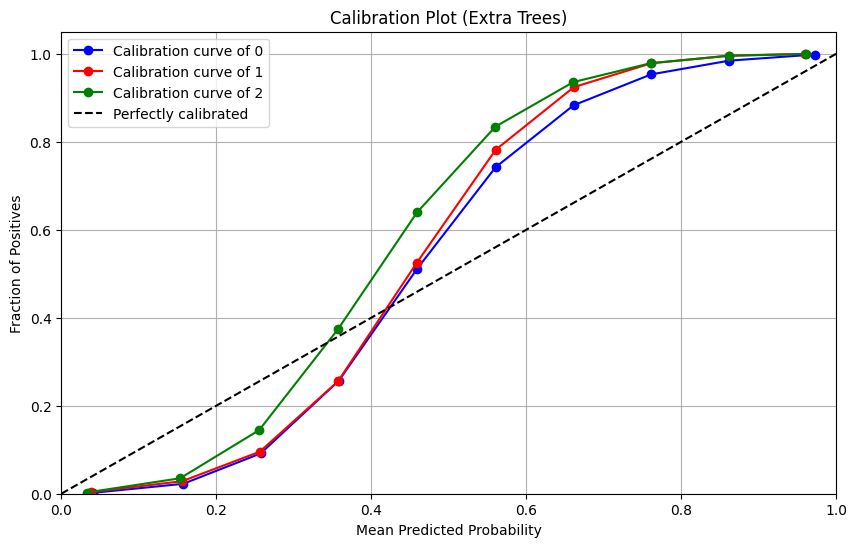


=== Calibration Scores ===
0: 0.124
1: 0.137
2: 0.139

=== Calibration Analysis (CatBoost) ===


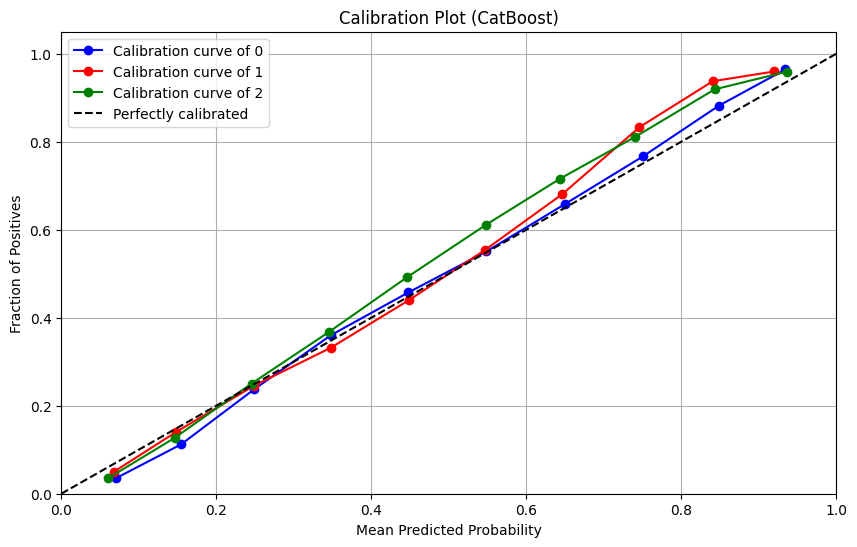


=== Calibration Scores ===
0: 0.020
1: 0.032
2: 0.042

=== Calibration Analysis (LightGBM) ===


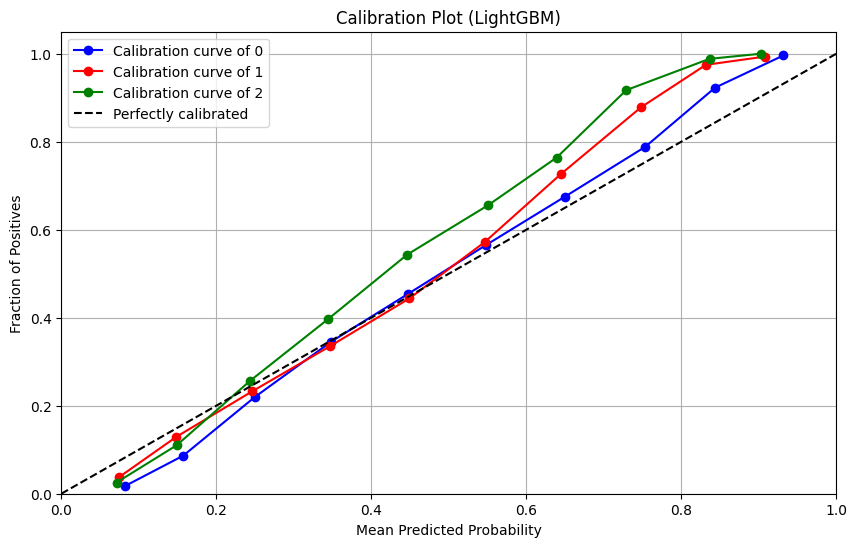


=== Calibration Scores ===
0: 0.040
1: 0.055
2: 0.091


In [ ]:
for name, model in models.items():
    print(f"\n=== Calibration Analysis ({name}) ===")

    # 예측 확률 생성
    y_pred_proba = model.predict_proba(X_test)

    # 클래스별 Calibration 정보 저장
    prob_true = dict()
    prob_pred = dict()
    calibration_scores = {}

    # 그래프 색상 설정
    colors = cycle(['blue', 'red', 'green'])

    # 캘리브레이션 곡선 계산
    plt.figure(figsize=(10, 6))
    for i, (color, class_name) in enumerate(zip(colors, np.unique(Y))):
        prob_true[i], prob_pred[i] = calibration_curve(
            (Y_test == class_name).astype(int),  # 다중 클래스 변환
            y_pred_proba[:, i],
            n_bins=10
        )
        # 신뢰도 계산 (절대 오차의 평균)
        calibration_scores[class_name] = np.mean(np.abs(prob_true[i] - prob_pred[i]))

        # Calibration Curve 그리기
        plt.plot(
            prob_pred[i],
            prob_true[i],
            marker='o',
            color=color,
            label=f'Calibration curve of {class_name}'
        )

    # 완벽히 보정된 모델 기준선 추가
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'Calibration Plot ({name})')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # Calibration Score 출력
    print("\n=== Calibration Scores ===")
    for class_name, score in calibration_scores.items():
        print(f"{class_name}: {score:.3f}")